## Linear Regression Using the Ames Housing Data

Using the Ames Housing Data:

Dean De Cock
Truman State University
Journal of Statistics Education Volume 19, Number 3(2011), www.amstat.org/publications/jse/v19n3/decock.pdf



In this notebook, we will build some linear regression models to predict housing prices from this data.  We will split our data into training and test sets, build various models on the training data and compare their results on the test set. We will examine metrics such as *mean squared error* and *mean absolute deviation*.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import ml_insights as mli

# To Plot matplotlib figures inline on the notebook
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, LassoCV

## Load the Data, Examine and Explore

In [2]:
## Load in the Ames Housing Data
datafile = "data/Ames_Housing_Data.tsv"
df=pd.read_csv(datafile, sep='\t')

In [3]:
## Examine the columns, look at missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

In [4]:
# This is recommended by the data set author to remove a few outliers

df = df.loc[df['Gr Liv Area']<=4000,:]
df.shape

(2925, 82)

There are a *lot* of variables, many of which have a lot of missing values.  Let's pick out just a few columns and start building models using that.

In [5]:
smaller_df= df.loc[:,['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add',
        'Gr Liv Area', 
        'Full Bath', 'Bedroom AbvGr',
        'Fireplaces', 'Garage Cars','SalePrice']]

In [6]:
smaller_df.describe()

,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Gr Liv Area,Full Bath,Bedroom AbvGr,Fireplaces,Garage Cars,SalePrice
count,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2924.000000,2925.000000
mean,10103.583590,6.088205,5.563761,1971.302906,1984.234188,1493.978803,1.564786,2.853675,0.596923,1.765048,180411.574701
std,7781.999124,1.402953,1.112262,30.242474,20.861774,486.273646,0.551386,0.827737,0.645349,0.759834,78554.857286
min,1300.000000,1.000000,1.000000,1872.000000,1950.000000,334.000000,0.000000,0.000000,0.000000,0.000000,12789.000000
25%,7438.000000,5.000000,5.000000,1954.000000,1965.000000,1126.000000,1.000000,2.000000,0.000000,1.000000,129500.000000
50%,9428.000000,6.000000,5.000000,1973.000000,1993.000000,1441.000000,2.000000,3.000000,1.000000,2.000000,160000.000000
75%,11515.000000,7.000000,6.000000,2001.000000,2004.000000,1740.000000,2.000000,3.000000,1.000000,2.000000,213500.000000
max,215245.000000,10.000000,9.000000,2010.000000,2010.000000,3820.000000,4.000000,8.000000,4.000000,5.000000,625000.000000


In [7]:
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 11 columns):
Lot Area          2925 non-null int64
Overall Qual      2925 non-null int64
Overall Cond      2925 non-null int64
Year Built        2925 non-null int64
Year Remod/Add    2925 non-null int64
Gr Liv Area       2925 non-null int64
Full Bath         2925 non-null int64
Bedroom AbvGr     2925 non-null int64
Fireplaces        2925 non-null int64
Garage Cars       2924 non-null float64
SalePrice         2925 non-null int64
dtypes: float64(1), int64(10)
memory usage: 274.2 KB


In [8]:
# There appears to be one NA in Garage Cars - fill with 0
smaller_df = smaller_df.fillna(0)

In [9]:
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 11 columns):
Lot Area          2925 non-null int64
Overall Qual      2925 non-null int64
Overall Cond      2925 non-null int64
Year Built        2925 non-null int64
Year Remod/Add    2925 non-null int64
Gr Liv Area       2925 non-null int64
Full Bath         2925 non-null int64
Bedroom AbvGr     2925 non-null int64
Fireplaces        2925 non-null int64
Garage Cars       2925 non-null float64
SalePrice         2925 non-null int64
dtypes: float64(1), int64(10)
memory usage: 274.2 KB


In [10]:
smaller_df.corr()

,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Gr Liv Area,Full Bath,Bedroom AbvGr,Fireplaces,Garage Cars,SalePrice
Lot Area,1.000000,0.083256,-0.032795,0.017049,0.015887,0.258529,0.121394,0.138169,0.247698,0.176047,0.270047
Overall Qual,0.083256,1.000000,-0.093902,0.596621,0.569498,0.564797,0.518713,0.061772,0.387174,0.598127,0.805236
Overall Cond,-0.032795,-0.093902,1.000000,-0.368533,0.048356,-0.116169,-0.214322,-0.006207,-0.030648,-0.181384,-0.103296
Year Built,0.017049,0.596621,-0.368533,1.000000,0.611444,0.239305,0.468485,-0.055650,0.167803,0.537146,0.565110
Year Remod/Add,0.015887,0.569498,0.048356,0.611444,1.000000,0.318860,0.456708,-0.021801,0.130699,0.423511,0.540290
Gr Liv Area,0.258529,0.564797,-0.116169,0.239305,0.318860,1.000000,0.637511,0.534222,0.449018,0.493222,0.719463
Full Bath,0.121394,0.518713,-0.214322,0.468485,0.456708,0.637511,1.000000,0.358727,0.225748,0.474841,0.544486
Bedroom AbvGr,0.138169,0.061772,-0.006207,-0.055650,-0.021801,0.534222,0.358727,1.000000,0.075856,0.090296,0.139766
Fireplaces,0.247698,0.387174,-0.030648,0.167803,0.130699,0.449018,0.225748,0.075856,1.000000,0.319385,0.474878
Garage Cars,0.176047,0.598127,-0.181384,0.537146,0.423511,0.493222,0.474841,0.090296,0.319385,1.000000,0.652227


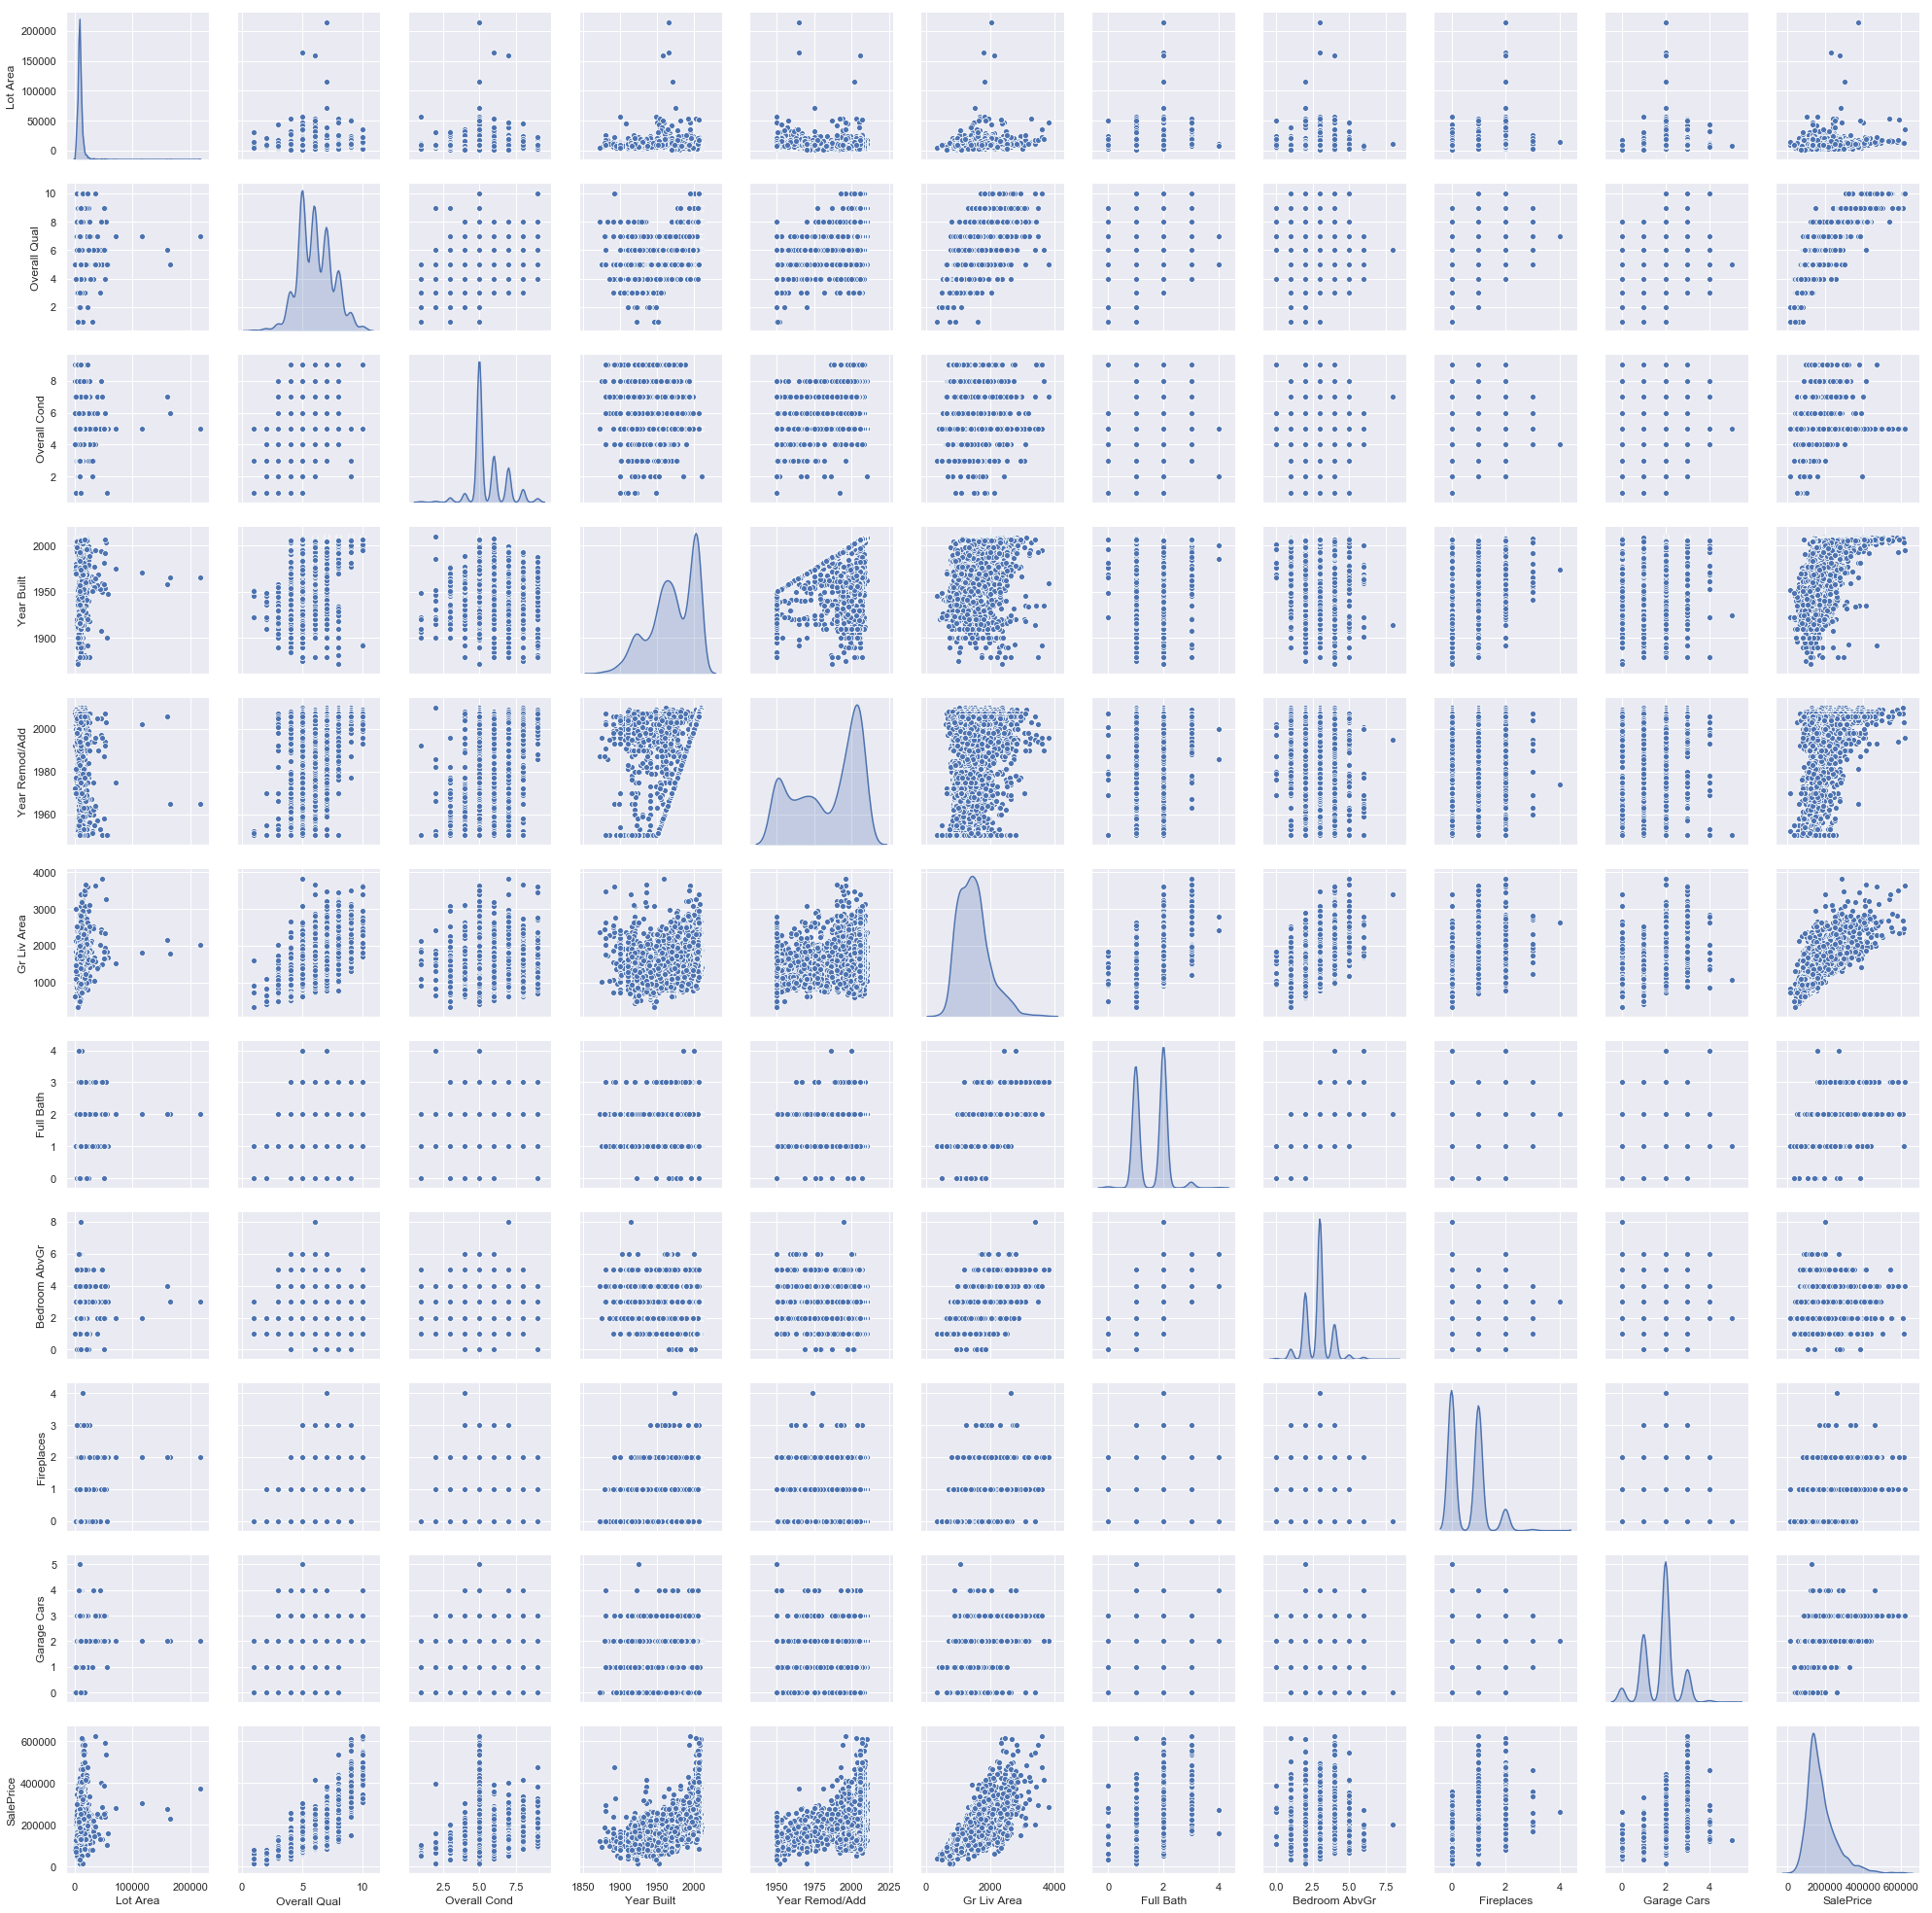

In [11]:
sns.set()
sns.pairplot(smaller_df, diag_kind='kde')

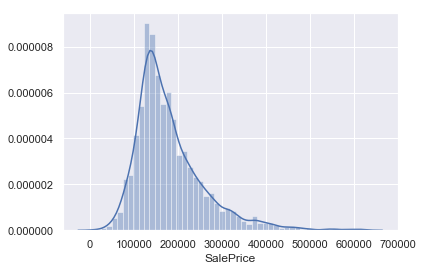

In [12]:
sns.distplot(smaller_df['SalePrice'])

### Data Exploration Questions
1. Which variables seem to have strong relationships with Sales Price?
1. The scatterplots of Year Built vs Year Add/Remod have an interesting structure.  Can you explain what is going on there?
1. In the plot of "Lot Area" vs. "SalePrice", some outliers are making the plot less visually useful.  How can we make the plot look better?

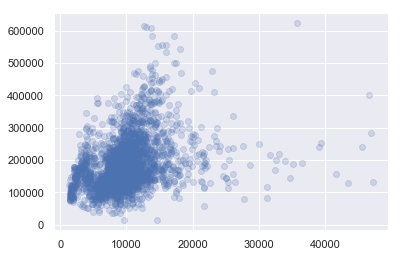

In [13]:
plt.scatter(smaller_df.loc[smaller_df['Lot Area']<50000,'Lot Area'], 
            smaller_df.loc[smaller_df['Lot Area']<50000,'SalePrice'], alpha=.2)

In [14]:
#Separate our features from our target

X=smaller_df.loc[:,['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add',
        'Gr Liv Area', 
        'Full Bath', 'Bedroom AbvGr',
        'Fireplaces', 'Garage Cars']]

y=smaller_df['SalePrice']

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 10 columns):
Lot Area          2925 non-null int64
Overall Qual      2925 non-null int64
Overall Cond      2925 non-null int64
Year Built        2925 non-null int64
Year Remod/Add    2925 non-null int64
Gr Liv Area       2925 non-null int64
Full Bath         2925 non-null int64
Bedroom AbvGr     2925 non-null int64
Fireplaces        2925 non-null int64
Garage Cars       2925 non-null float64
dtypes: float64(1), int64(9)
memory usage: 331.4 KB


In [16]:
#Split the data 70-30 train/test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [17]:
X_train.columns

Index(['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Gr Liv Area', 'Full Bath', 'Bedroom AbvGr',
       'Fireplaces', 'Garage Cars'],
      dtype='object')

In [18]:
X_train.shape

(2047, 10)

In [19]:
X_test.shape

(878, 10)

In [20]:
X.shape

(2925, 10)

## One Variable Linear Regression
To begin, we will do a simple one variable linear regression, predicting the Sales Price using the Square Footage (Gr Liv Area) of the house.

In [21]:
# First let us fit only on Living Area (sqft)
selected_columns_1 = ['Gr Liv Area']

In [22]:
lr_model1 = LinearRegression()
lr_model1.fit(X_train.loc[:,selected_columns_1],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [23]:
lr_model1.coef_, lr_model1.intercept_

(array([112.05335187]), 12169.835728455451)

### Comprehension Question
What do the coefficients above represent?  How can they be interpreted?

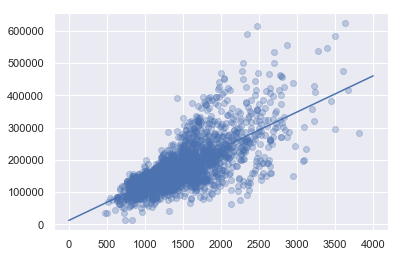

In [24]:
plt.scatter(X_train['Gr Liv Area'],y_train,alpha=.3)
vec1 = np.linspace(0,4000,1000)
plt.plot(vec1, lr_model1.intercept_ + lr_model1.coef_[0]*vec1)

In [25]:
### Get the predictions on the training set
train_set_pred1 = lr_model1.predict(X_train.loc[:,selected_columns_1])

In [26]:
### Get the predictions on the test set
test_set_pred1 = lr_model1.predict(X_test.loc[:,selected_columns_1])

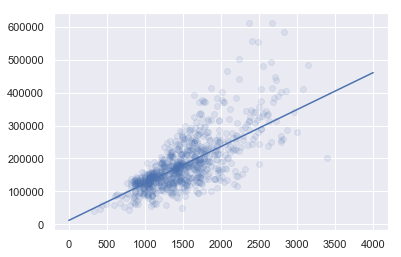

In [27]:
### Plot the regression line on top of the data

plt.scatter(X_test['Gr Liv Area'],y_test,alpha=.1)
vec1 = np.linspace(0,4000,1000)
plt.plot(vec1, lr_model1.intercept_ + lr_model1.coef_[0]*vec1)

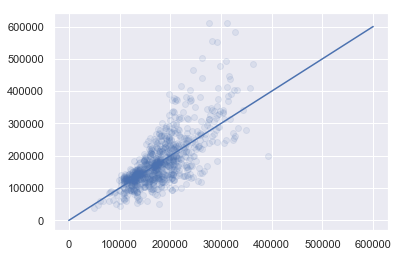

In [28]:
## Plot predicted vs actual 

plt.scatter(test_set_pred1,y_test,alpha=.1)
plt.plot(np.linspace(0,600000,1000),np.linspace(0,600000,1000))

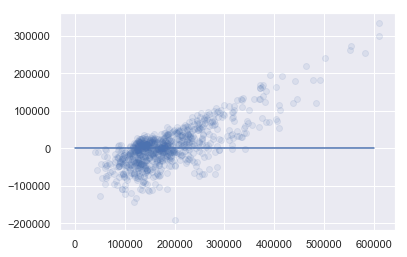

In [29]:
## Residual Plot
## Plot predicted vs actual 

plt.scatter(y_test,y_test-test_set_pred1,alpha=.1)
plt.plot(np.linspace(0,600000,1000),np.linspace(0,0,1000))

In [30]:
# How good is our model on the test set?

# Root Mean Square Error
np.sqrt(np.mean((test_set_pred1 - y_test)**2))

55396.91478545596

In [31]:
# Mean Absolute Deviation
(np.mean(np.abs(test_set_pred1 - y_test)))

38254.52256793792

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [33]:
np.sqrt(mean_squared_error(y_test, test_set_pred1)), mean_absolute_error(y_test,test_set_pred1)

(55396.91478545597, 38254.52256793799)

### Multiple Linear Regression
We will now do a regression on several variables.  We will no longer be able to see the regression line so simply in a graph, but we can still look at the predicted vs actual and residual plots

In [34]:
selected_columns_2 = ['Lot Area', 'Overall Qual', 'Year Built', 'Gr Liv Area']

In [35]:
lr_model2 = LinearRegression()
lr_model2.fit(X_train.loc[:,selected_columns_2],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [36]:
lr_model2.coef_

array([1.56256997e+00, 2.58564462e+04, 5.19205946e+02, 5.78490930e+01])

In [37]:
lr_model2.intercept_

-1102707.331255561

In [38]:
list(zip(selected_columns_2,lr_model2.coef_))

[('Lot Area', 1.562569965379118),
 ('Overall Qual', 25856.446165844027),
 ('Year Built', 519.2059458552159),
 ('Gr Liv Area', 57.84909297212535)]

### Comprehension Question
What do these coefficients mean?  Why does `'Gr Liv Area'` have a different coefficient this time?

In [39]:
X.corr()

,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Gr Liv Area,Full Bath,Bedroom AbvGr,Fireplaces,Garage Cars
Lot Area,1.000000,0.083256,-0.032795,0.017049,0.015887,0.258529,0.121394,0.138169,0.247698,0.176047
Overall Qual,0.083256,1.000000,-0.093902,0.596621,0.569498,0.564797,0.518713,0.061772,0.387174,0.598127
Overall Cond,-0.032795,-0.093902,1.000000,-0.368533,0.048356,-0.116169,-0.214322,-0.006207,-0.030648,-0.181384
Year Built,0.017049,0.596621,-0.368533,1.000000,0.611444,0.239305,0.468485,-0.055650,0.167803,0.537146
Year Remod/Add,0.015887,0.569498,0.048356,0.611444,1.000000,0.318860,0.456708,-0.021801,0.130699,0.423511
Gr Liv Area,0.258529,0.564797,-0.116169,0.239305,0.318860,1.000000,0.637511,0.534222,0.449018,0.493222
Full Bath,0.121394,0.518713,-0.214322,0.468485,0.456708,0.637511,1.000000,0.358727,0.225748,0.474841
Bedroom AbvGr,0.138169,0.061772,-0.006207,-0.055650,-0.021801,0.534222,0.358727,1.000000,0.075856,0.090296
Fireplaces,0.247698,0.387174,-0.030648,0.167803,0.130699,0.449018,0.225748,0.075856,1.000000,0.319385
Garage Cars,0.176047,0.598127,-0.181384,0.537146,0.423511,0.493222,0.474841,0.090296,0.319385,1.000000


In [40]:
test_set_pred2 = lr_model2.predict(X_test.loc[:,selected_columns_2])

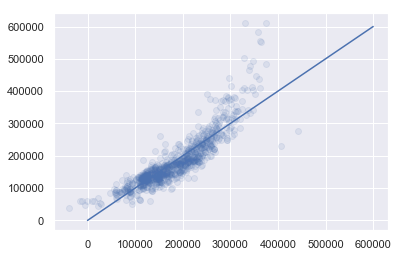

In [41]:
plt.scatter(test_set_pred2,y_test,alpha=.1)
plt.plot(np.linspace(0,600000,1000),np.linspace(0,600000,1000))

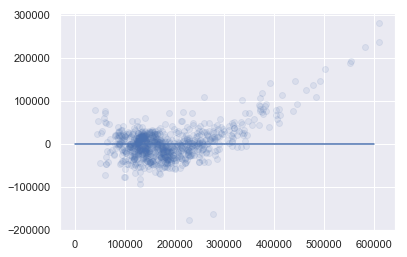

In [42]:
plt.scatter(y_test, y_test-test_set_pred2,alpha=.1)
plt.plot(np.linspace(0,600000,1000),np.linspace(0,0,1000))

In [43]:
#RMSE
np.sqrt(np.mean((test_set_pred2 - y_test)**2))

37638.85039344931

In [44]:
#MAD
(np.mean(np.abs(test_set_pred2 - y_test)))

25686.833930193672

Next, let us try using all of the variables (in the reduced selection)

In [45]:
lr_model3 = LinearRegression()
lr_model3.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [46]:
list(zip(X_train.columns,lr_model3.coef_))

[('Lot Area', 1.4004320218659674),
 ('Overall Qual', 20121.193329127895),
 ('Overall Cond', 5375.766772142535),
 ('Year Built', 555.7952107818119),
 ('Year Remod/Add', 125.75290884195269),
 ('Gr Liv Area', 73.0852518021986),
 ('Full Bath', -9259.533699227452),
 ('Bedroom AbvGr', -10307.987722698346),
 ('Fireplaces', 4668.006607546887),
 ('Garage Cars', 9931.570009396906)]

In [47]:
test_set_pred3 = lr_model3.predict(X_test)

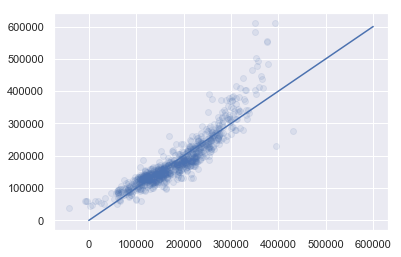

In [48]:
plt.scatter(test_set_pred3,y_test,alpha=.1)
plt.plot(np.linspace(0,600000,1000),np.linspace(0,600000,1000))

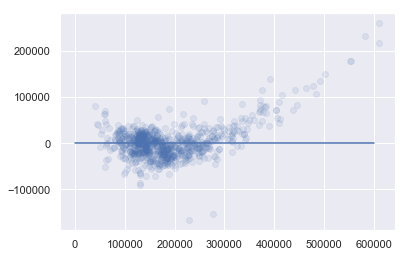

In [49]:
plt.scatter(y_test,y_test-test_set_pred3,alpha=.1)
plt.plot(np.linspace(0,600000,1000),np.linspace(0,0,1000))

In [50]:
#RMSE
np.sqrt(np.mean((test_set_pred3 - y_test)**2))

34427.46045160037

In [51]:
#MAD
(np.mean(np.abs(test_set_pred3 - y_test)))

23113.614375666828

### Adding a quadratic factor
Again, we see that our residual plot indicates some non-linearity.

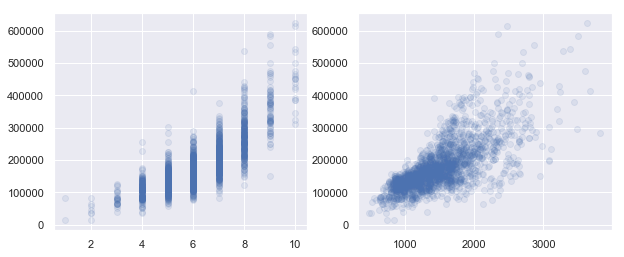

In [52]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].scatter(X_train['Overall Qual'],y_train, alpha = .1)

ax[1].scatter(X_train['Gr Liv Area'],y_train, alpha = .1)

Let's try adding in `'Overall Qual'` *squared* as a predictor variable

In [53]:
X['OQ2'] = X['Overall Qual']**2
X.columns

Index(['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Gr Liv Area', 'Full Bath', 'Bedroom AbvGr',
       'Fireplaces', 'Garage Cars', 'OQ2'],
      dtype='object')

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [55]:
lr_model4 = LinearRegression()
lr_model4.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [56]:
list(zip(X_train.columns,lr_model4.coef_))

[('Lot Area', 1.3215582849560275),
 ('Overall Qual', -56025.99454155888),
 ('Overall Cond', 9050.932619627192),
 ('Year Built', 650.998783602246),
 ('Year Remod/Add', 76.50736116235278),
 ('Gr Liv Area', 63.08402960167803),
 ('Full Bath', -6605.568595162768),
 ('Bedroom AbvGr', -4945.572422170533),
 ('Fireplaces', 7564.675614986654),
 ('Garage Cars', 8379.339235671405),
 ('OQ2', 6158.632580077787)]

In [57]:
lr_model4.score(X_test, y_test)

0.8621640497600933

In [58]:
test_set_pred4 = lr_model4.predict(X_test)

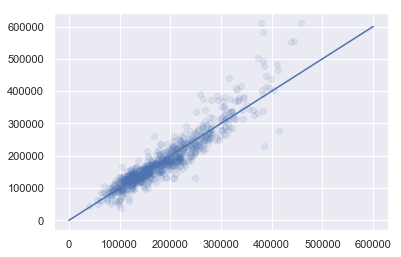

In [59]:
plt.scatter(test_set_pred4,y_test,alpha=.1)
plt.plot(np.linspace(0,600000,1000),np.linspace(0,600000,1000))

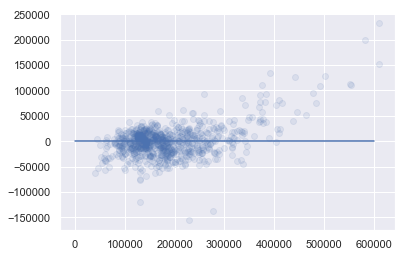

In [60]:
plt.scatter(y_test,y_test-test_set_pred4,alpha=.1)
plt.plot(np.linspace(0,600000,1000),np.linspace(0,0,1000))

In [61]:
#RMSE
np.sqrt(np.mean((test_set_pred4 - y_test)**2))

29882.138332373142

In [62]:
#MAD
(np.mean(np.abs(test_set_pred4 - y_test)))

20137.742795243663

In [63]:
X.head()

,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Gr Liv Area,Full Bath,Bedroom AbvGr,Fireplaces,Garage Cars,OQ2
0,31770,6,5,1960,1960,1656,1,3,2,2.0,36
1,11622,5,6,1961,1961,896,1,2,0,1.0,25
2,14267,6,6,1958,1958,1329,1,3,0,1.0,36
3,11160,7,5,1968,1968,2110,2,3,2,2.0,49
4,13830,5,5,1997,1998,1629,2,3,1,2.0,25


In [64]:
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

poly = PolynomialFeatures()

X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)


In [65]:
X_train.shape

(2047, 78)

In [66]:
lr_model5 = LinearRegression()
lr_model5.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [67]:
lr_model5.score(X_test, y_test)

0.9076166536087734

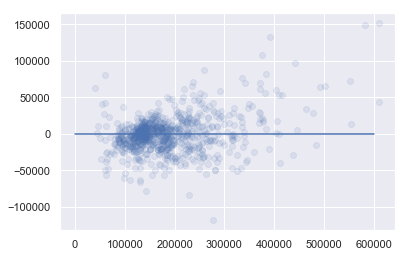

In [68]:
plt.scatter(y_test,y_test-lr_model5.predict(X_test),alpha=.1)
plt.plot(np.linspace(0,600000,1000),np.linspace(0,0,1000))

In [69]:
poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x8',
 'x9',
 'x10',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x0 x6',
 'x0 x7',
 'x0 x8',
 'x0 x9',
 'x0 x10',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x1 x5',
 'x1 x6',
 'x1 x7',
 'x1 x8',
 'x1 x9',
 'x1 x10',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x2 x5',
 'x2 x6',
 'x2 x7',
 'x2 x8',
 'x2 x9',
 'x2 x10',
 'x3^2',
 'x3 x4',
 'x3 x5',
 'x3 x6',
 'x3 x7',
 'x3 x8',
 'x3 x9',
 'x3 x10',
 'x4^2',
 'x4 x5',
 'x4 x6',
 'x4 x7',
 'x4 x8',
 'x4 x9',
 'x4 x10',
 'x5^2',
 'x5 x6',
 'x5 x7',
 'x5 x8',
 'x5 x9',
 'x5 x10',
 'x6^2',
 'x6 x7',
 'x6 x8',
 'x6 x9',
 'x6 x10',
 'x7^2',
 'x7 x8',
 'x7 x9',
 'x7 x10',
 'x8^2',
 'x8 x9',
 'x8 x10',
 'x9^2',
 'x9 x10',
 'x10^2']